In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import hashlib


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

root_dir = "/home/radar-data/radar_data/"

In [2]:
# Load the .npy files into a list
npy_files = sorted(glob(root_dir + 'data/npy_files/*.npy'))

# Load the first .npy file to get the unique latitudes and longitudes of this data set
example_grid = np.load(npy_files[0])
unique_latitudes = example_grid.shape[1]
unique_longitudes = example_grid.shape[2]

In [3]:
for i in enumerate(npy_files):
    array = np.load(i[1])
    
    array[array < 20] = 0

    np.save(i[1], array)

In [4]:
# Assume npy_files and unique_latitudes, unique_longitudes are already defined
sequence_length = 15 # Number of .npy files to look back on
prediction_horizon = 15 # Number of .npy files to predict
height, width = unique_latitudes, unique_longitudes

In [5]:
# Function to split a single grid into 250x250 squares
def split_single_grid(file, square_size=250, height=3500, width=7000):
    grid = np.load(file).reshape(height, width, 1)
    squares = [
        grid[i:i+square_size, j:j+square_size]
        for i in range(0, height, square_size)
        for j in range(0, width, square_size)
    ]
    return np.array(squares)

# Function to split all grids sequentially (no parallelization)
def split_all_grids_sequential(npy_files, square_size=250, height=3500, width=7000):
    num_squares_per_grid = (height // square_size) * (width // square_size)
    num_files = len(npy_files)

    # Preallocate space for all the grids that will be split into squares
    all_squares = np.empty((num_files, num_squares_per_grid, square_size, square_size, 1), dtype=np.float32)

    # Sequentially process each file and store the result
    for idx, file in enumerate(npy_files):
        squares = split_single_grid(file, square_size, height, width)
        all_squares[idx] = squares

    return all_squares

# Assume npy_files, sequence_length, and prediction_horizon are already defined
square_size = 250
height, width = 3500, 7000  # Original image size
num_squares = 392

# Pre-split all grids into squares sequentially
all_squares = split_all_grids_sequential(npy_files, square_size=square_size, height=height, width=width)

# Now, treat each square as an independent sample
num_files = len(npy_files)
num_samples = (num_files - sequence_length - prediction_horizon + 1) * num_squares

# Pre-allocate arrays for input (X) and output (y) sequences
X = np.empty((num_samples, sequence_length, square_size, square_size, 1), dtype=np.float32)
y = np.empty((num_samples, prediction_horizon, square_size, square_size, 1), dtype=np.float32)

# Populate X and y arrays using pre-split squares
sample_idx = 0
for i in range(num_files - sequence_length - prediction_horizon + 1):
    for j in range(num_squares):
        # For each sample, take the sequence for that square over time
        x_sample = all_squares[i:i+sequence_length, j]
        X[sample_idx] = x_sample

        y_sample = all_squares[i+sequence_length:i+sequence_length+prediction_horizon, j]
        y[sample_idx] = y_sample

        sample_idx += 1

In [6]:
def remove_duplicates(X, y):
    """
    Removes duplicates from X and y where every pixel in the image sequences is the same.
    Only unique (X, y) pairs are retained.
    
    Args:
    - X: numpy array of shape (num_samples, sequence_length, image_width, image_height, 1)
    - y: numpy array of shape (num_samples, prediction_horizon, image_width, image_height, 1)
    
    Returns:
    - X_unique: numpy array of unique input sequences
    - y_unique: numpy array of corresponding unique output sequences
    """
    unique_indices = []
    num_samples = X.shape[0]
    
    # Track whether we've already seen a duplicate
    seen = np.zeros(num_samples, dtype=bool)
    
    for i in range(num_samples):
        if seen[i]:
            continue  # Skip if this sample was already identified as a duplicate
        
        # Mark the current sample as part of the unique set
        unique_indices.append(i)
        
        # Check for duplicates in the rest of the dataset
        for j in range(i + 1, num_samples):
            if seen[j]:
                continue  # Skip already marked duplicates
            
            # Check if both X and y sequences are identical
            if np.array_equal(X[i], X[j]) and np.array_equal(y[i], y[j]):
                seen[j] = True  # Mark this as a duplicate
    
    # Select only the unique indices for X and y
    X_unique = X[unique_indices]
    y_unique = y[unique_indices]
    
    return X_unique, y_unique

X_unique, y_unique = remove_duplicates(X, y)

In [7]:
# Split data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split: train and temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_unique, y_unique, test_size=(1 - train_ratio)
)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_ratio / (test_ratio + val_ratio))
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(366, 15, 250, 250, 1)
(78, 15, 250, 250, 1)
(79, 15, 250, 250, 1)
(366, 15, 250, 250, 1)
(78, 15, 250, 250, 1)
(79, 15, 250, 250, 1)


Frame x - 2 is the same as the previous frame.
Frame x - 3 is the same as the previous frame.
Frame x - 4 is the same as the previous frame.
Frame x - 5 is the same as the previous frame.
Frame x - 6 is the same as the previous frame.
Frame x - 7 is the same as the previous frame.
Frame x - 8 is the same as the previous frame.
Frame x - 9 is the same as the previous frame.
Frame x - 10 is the same as the previous frame.
Frame x - 11 is the same as the previous frame.
Frame x - 13 is the same as the previous frame.
Frame x - 14 is the same as the previous frame.
Displaying frames for example 29.
Frame y - 1 is the same as the previous frame.
Frame y - 2 is the same as the previous frame.
Frame y - 3 is the same as the previous frame.
Frame y - 4 is the same as the previous frame.
Frame y - 5 is the same as the previous frame.
Frame y - 6 is the same as the previous frame.
Frame y - 7 is the same as the previous frame.
Frame y - 8 is the same as the previous frame.
Frame y - 9 is the sam

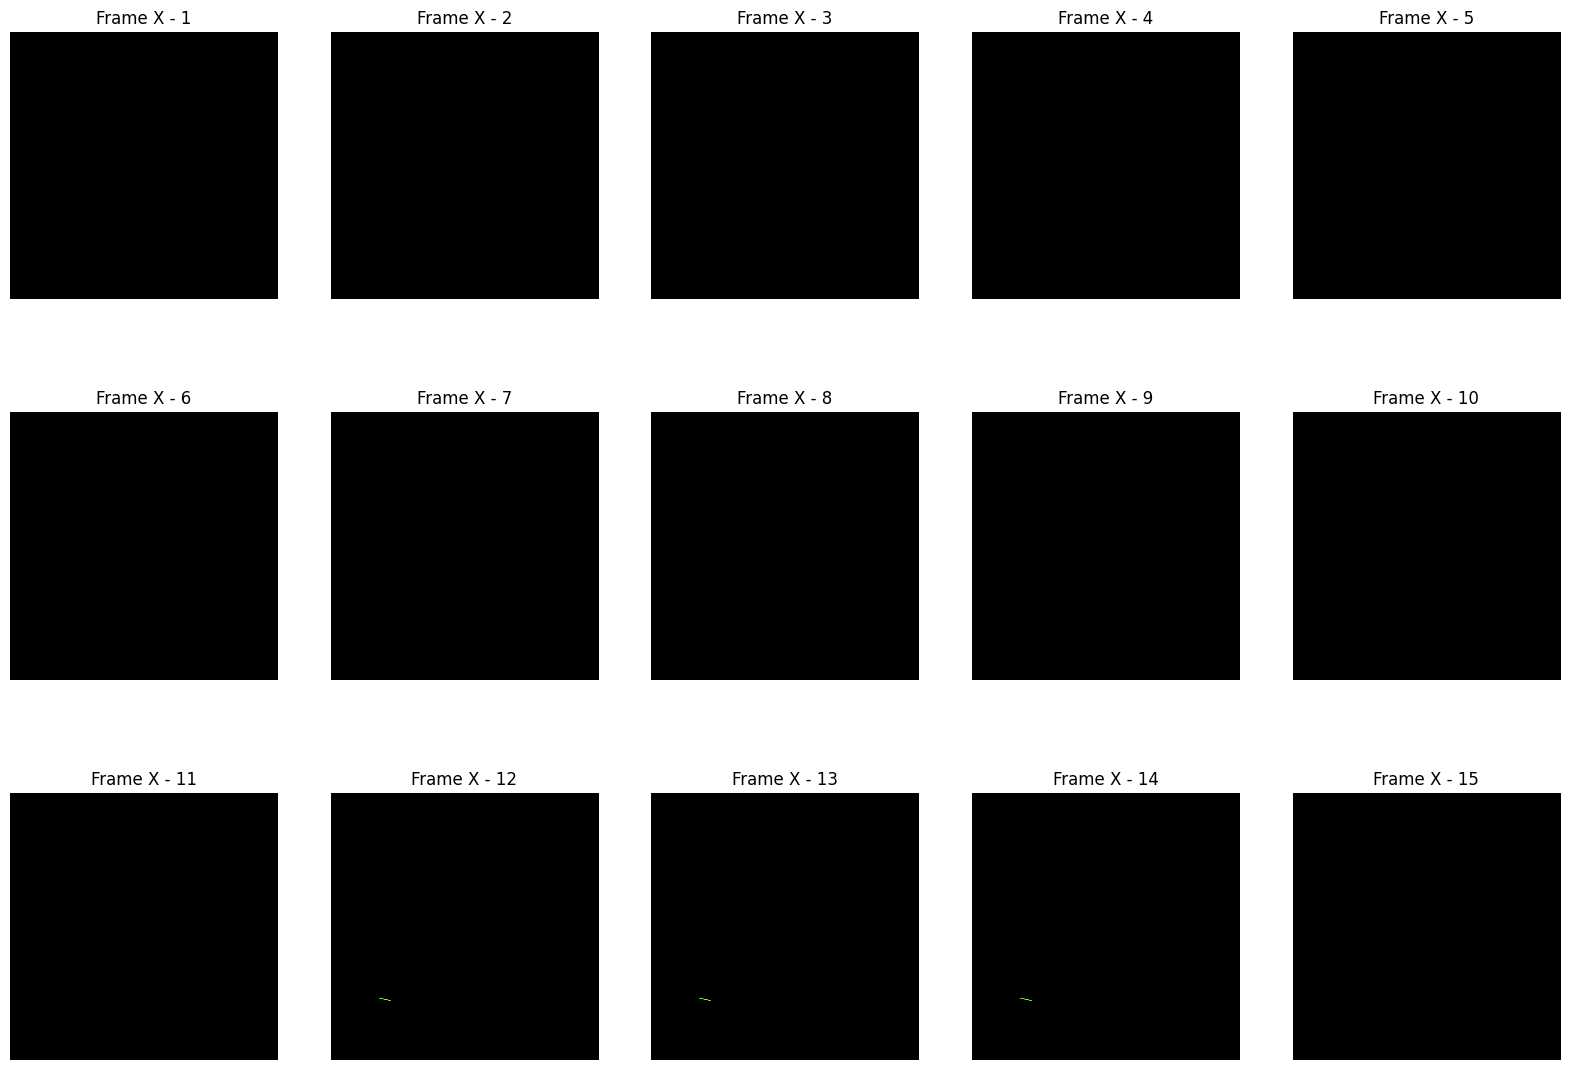

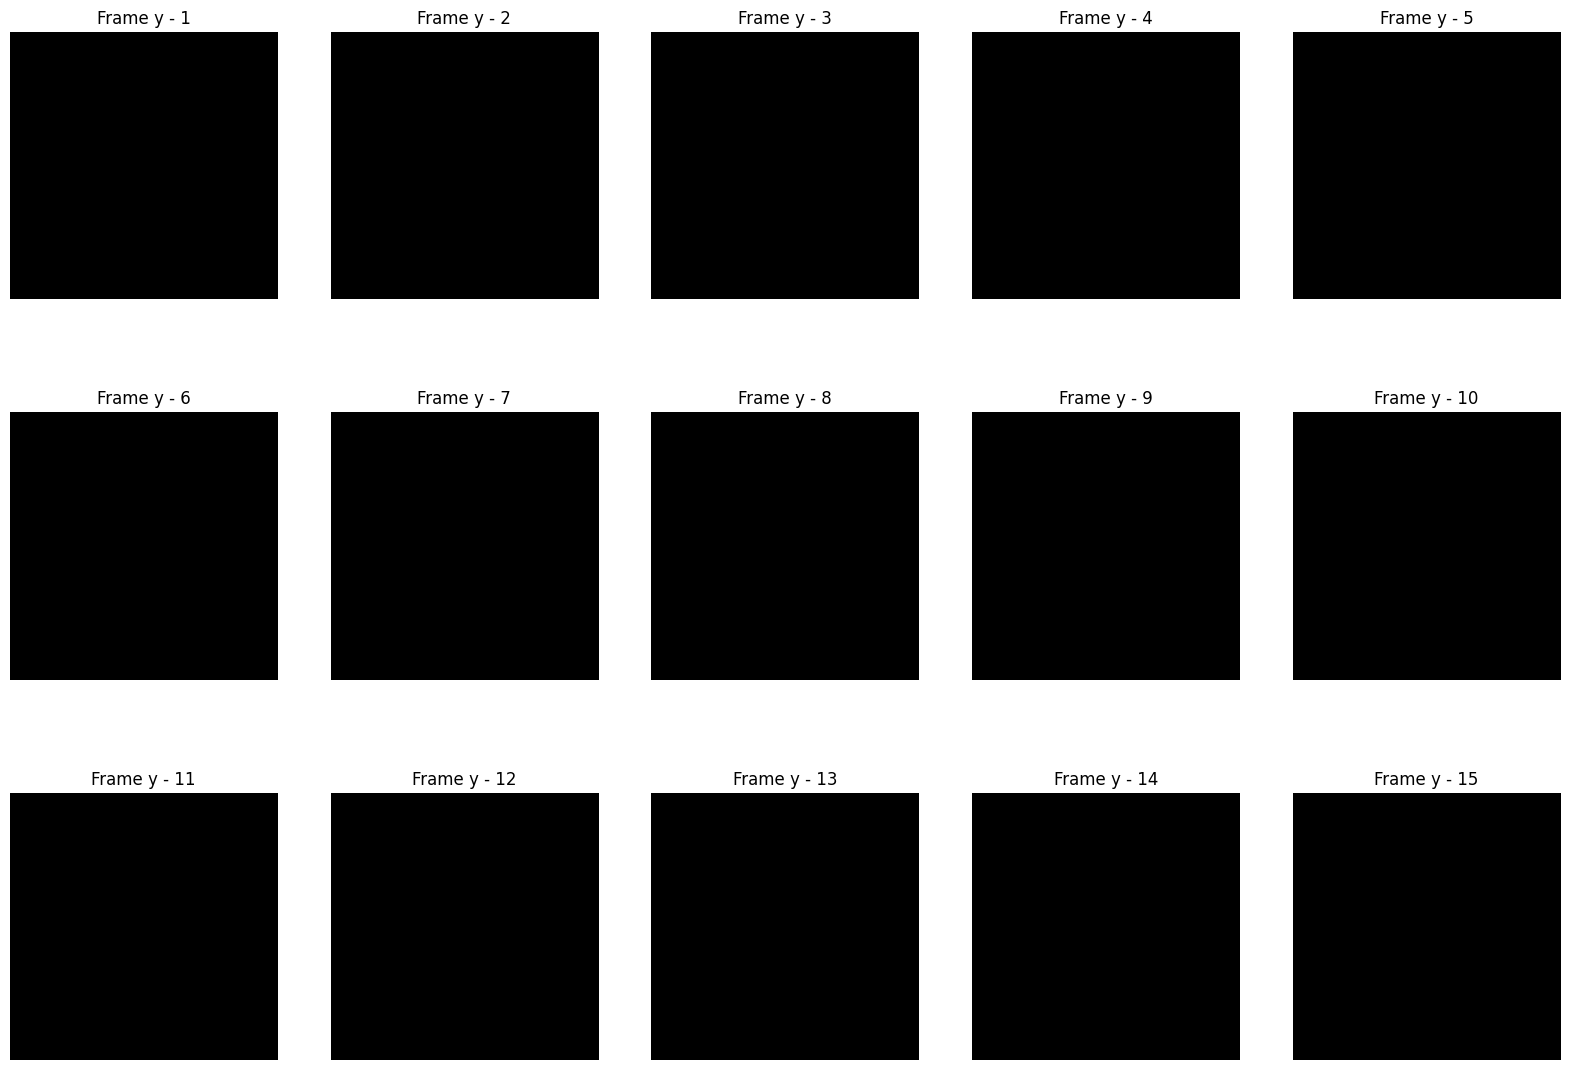

In [8]:
# Define the colors for the radar map, introducing white for values between 0 and 15
colors = [
    (0, 0, 0),         # White for values 0-15 (no precipitation or very light)
    (0, 0.7, 0),       # Green (light precipitation)
    (1, 1, 0),         # Yellow (moderate precipitation)
    (1, 0.65, 0),      # Orange (heavy precipitation)
    (1, 0, 0),         # Red (very heavy precipitation)
    (0.6, 0, 0.6)      # Purple (extreme precipitation)
]

# Define the breakpoints for the color transition, where 0-15 is white
breakpoints = [0.0, 15/80.0, 40/80.0, 60/80.0, 70/80.0, 1.0]

# Create the custom colormap
radar_cmap = LinearSegmentedColormap.from_list('radar', colors, N=256)

# Normalize the data range from 0 to 80
norm = Normalize(vmin=0, vmax=80)

# Construct a figure to visualize the images
x_fig, x_axes = plt.subplots(3, 5, figsize=(20, 14))
y_fig, y_axes = plt.subplots(3, 5, figsize=(20, 14))

# Randomly choose a data example to visualize
data_choice = np.random.choice(range(len(X_train)), size=1)[0]
lastdata = None  # Initialize lastdata to None before looping

# Plot each of the sequential images for one random data example
for idx, ax in enumerate(x_axes.flat):
    x_thisdata = X_train[data_choice][idx]

    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(x_thisdata, lastdata):
        print(f"Frame x - {idx + 1} is the same as the previous frame.")

    # Display the image with the radar colormap and normalization
    im = ax.imshow(np.squeeze(x_thisdata), cmap=radar_cmap, norm=norm)
    
    # Add title and remove axis
    ax.set_title(f"Frame X - {idx + 1}")
    ax.axis("off")

    # Update lastdata
    lastdata = x_thisdata

# Print information and display the figure
print(f"Displaying frames for example {data_choice}.")

for idx, ax in enumerate(y_axes.flat):
    y_thisdata = y_train[data_choice][idx]

    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(y_thisdata, lastdata):
        print(f"Frame y - {idx + 1} is the same as the previous frame.")

    # Display the image with the radar colormap and normalization
    im = ax.imshow(np.squeeze(y_thisdata), cmap=radar_cmap, norm=norm)
    
    # Add title and remove axis
    ax.set_title(f"Frame y - {idx + 1}")
    ax.axis("off")

    # Update lastdata
    lastdata = y_thisdata

plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from tensorflow.keras.optimizers import Adam
import subprocess

# channels = 1  # Reflectivity is your feature, so 1 channel

# # Define the model using an Input layer for the input shape
# model = Sequential()

# # Add Input Layer
# model.add(Input(shape=(sequence_length, square_size, square_size, channels))) 

# # First ConvLSTM2D layer with return_sequences=True
# model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
# model.add(BatchNormalization())

# # Second ConvLSTM2D layer with return_sequences=True to return all frames
# model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
# model.add(BatchNormalization())

# # Replace Conv3D with Conv2D to predict the next frame(s)
# model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same'))

# # Compile the model
# model.compile(loss='mse', optimizer='adam')

# # Print model summary
# model.summary()

2024-10-14 03:44:35.142686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 03:44:35.153825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 03:44:35.157203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 03:44:35.166131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 03:44:35.905476: W tensorflow/compiler/tf2

In [10]:
model_name = "model6_3.keras"
model = load_model(root_dir + f"model/{model_name}")
# Create an Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Set the learning rate here

# Compile the model with the optimizer
model.compile(loss='mse', optimizer=optimizer)

2024-10-14 03:44:36.725302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22403 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:48:00.0, compute capability: 8.9
2024-10-14 03:44:36.726204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22403 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:49:00.0, compute capability: 8.9


In [11]:
def get_model_memory_usage(batch_size, model):
    features_mem = 0  # Initialize memory for features
    float_bytes = 4.0  # Float32 uses 4 bytes
    
    for layer in model.layers:
        # Use layer.output.shape to get the output shape instead of output_shape
        out_shape = layer.output.shape
        
        # Remove the batch size dimension (out_shape[0]) and None (which represents the batch dimension)
        out_shape = [dim for dim in out_shape if dim is not None]
        
        # Multiply all output shape dimensions to calculate the number of elements per layer
        single_layer_mem = 1
        for s in out_shape:
            single_layer_mem *= s
            
        # Convert to memory (in bytes and MB)
        single_layer_mem_float = single_layer_mem * float_bytes  # Multiply by 4 bytes (float32)
        single_layer_mem_MB = single_layer_mem_float / (1024 ** 2)  # Convert to MB
        
        print(f"Memory for layer {layer.name} with output shape {out_shape} is: {single_layer_mem_MB:.2f} MB")
        
        features_mem += single_layer_mem_MB  # Accumulate total feature memory
    
    # Calculate Parameter memory
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB = ((trainable_wts + non_trainable_wts) * float_bytes) / (1024 ** 2)
    
    print("_________________________________________")
    print(f"Memory for features in MB is: {features_mem * batch_size:.2f} MB")
    print(f"Memory for parameters in MB is: {parameter_mem_MB:.2f} MB")

    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB
    total_memory_GB = total_memory_MB / 1024  # Convert to GB
    
    return total_memory_GB

#####################################################################

mem_for_my_model = get_model_memory_usage(1, model)

print("_________________________________________")
print("Minimum memory required to work with this model is: %.2f" %mem_for_my_model, "GB")

Memory for layer conv_lstm2d with output shape [15, 250, 250, 64] is: 228.88 MB
Memory for layer batch_normalization with output shape [15, 250, 250, 64] is: 228.88 MB
Memory for layer conv_lstm2d_1 with output shape [15, 250, 250, 64] is: 228.88 MB
Memory for layer batch_normalization_1 with output shape [15, 250, 250, 64] is: 228.88 MB
Memory for layer conv3d with output shape [15, 250, 250, 1] is: 3.58 MB
_________________________________________
Memory for features in MB is: 919.10 MB
Memory for parameters in MB is: 1.71 MB
_________________________________________
Minimum memory required to work with this model is: 0.90 GB


In [12]:
cp = ModelCheckpoint(root_dir + f"model/{model_name}", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train the model
history = model.fit(X_train, y_train, 
          batch_size=2, 
          epochs=200, 
          callbacks=[cp, early_stopping],
          validation_data=(X_val, y_val))

Epoch 1/200


I0000 00:00:1728877482.160460   45582 service.cc:146] XLA service 0x5587d99875b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728877482.160789   45582 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1728877482.160795   45582 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-14 03:44:42.238647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-14 03:44:42.484960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1728877484.291125   45582 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728877484.371659   45582 gpu_timer.cc:183] Delay kernel

183/183 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - loss: 8.8750 - val_loss: 12.2839
Epoch 2/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 11.0465 - val_loss: 13.6662
Epoch 3/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 8.8448 - val_loss: 12.0714
Epoch 4/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 8.9330 - val_loss: 11.8740
Epoch 5/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 9.1158 - val_loss: 12.8153
Epoch 6/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 8.8945 - val_loss: 12.3445
Epoch 7/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 8.7541 - val_loss: 12.1736
Epoch 8/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 8.3316 - val_loss: 11.7942
Epoch 9/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 7.5221 - val_loss: 12.5067
Epoch 10/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - loss: 8.9726 - val_loss: 11.5414
Epoch 11/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - loss: 9.6997 - val_loss: 13.7095
Epoch 12

In [13]:
# Path to the model saved by ModelCheckpoint
model_path = root_dir + f"model/{model_name}"

# Extract last val_accuracy/val_loss from the training history
val_loss = history.history['val_loss']

# Commit and push the model to GitHub
commit_message = f"Add trained model with val_loss: {val_loss}"

commands = [
    "git config --global user.email 'tw@trevorwiebe.com'",
    "git config --global user.name 'Trevor Wiebe'",
    f"git add {model_path}",  # Assuming `model_path` is where your model is saved
    f'git commit -m "{commit_message}"',
    "git push"
]

# Execute Git commands
for command in commands:
    try:
        subprocess.run(command, check=True, shell=True)
        print(f"Successfully executed: {command}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while executing: {command}\nError: {e}")

Successfully executed: git config --global user.email 'tw@trevorwiebe.com'
Successfully executed: git config --global user.name 'Trevor Wiebe'
Successfully executed: git add /home/radar-data/radar_data/model/model6_3.keras
[detached HEAD 63ddb46] Add trained model with val_loss: [12.283885955810547, 13.666208267211914, 12.071369171142578, 11.873960494995117, 12.815305709838867, 12.344533920288086, 12.173583984375, 11.794206619262695, 12.506736755371094, 11.541427612304688, 13.709457397460938, 14.636787414550781, 12.074158668518066, 12.910661697387695, 12.736138343811035, 13.796211242675781, 12.04664134979248, 11.680482864379883, 11.333038330078125, 13.419325828552246, 13.062467575073242, 14.12056827545166, 12.770003318786621, 12.696528434753418, 12.819390296936035, 12.857621192932129, 13.564614295959473, 12.873175621032715, 12.571162223815918]
 2 files changed, 741 insertions(+), 553 deletions(-)
 rewrite radar_data/notebooks/radar_data_processing_6.ipynb (98%)
Successfully executed: g

fatal: You are not currently on a branch.
To push the history leading to the current (detached HEAD)
state now, use

    git push origin HEAD:<name-of-remote-branch>



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


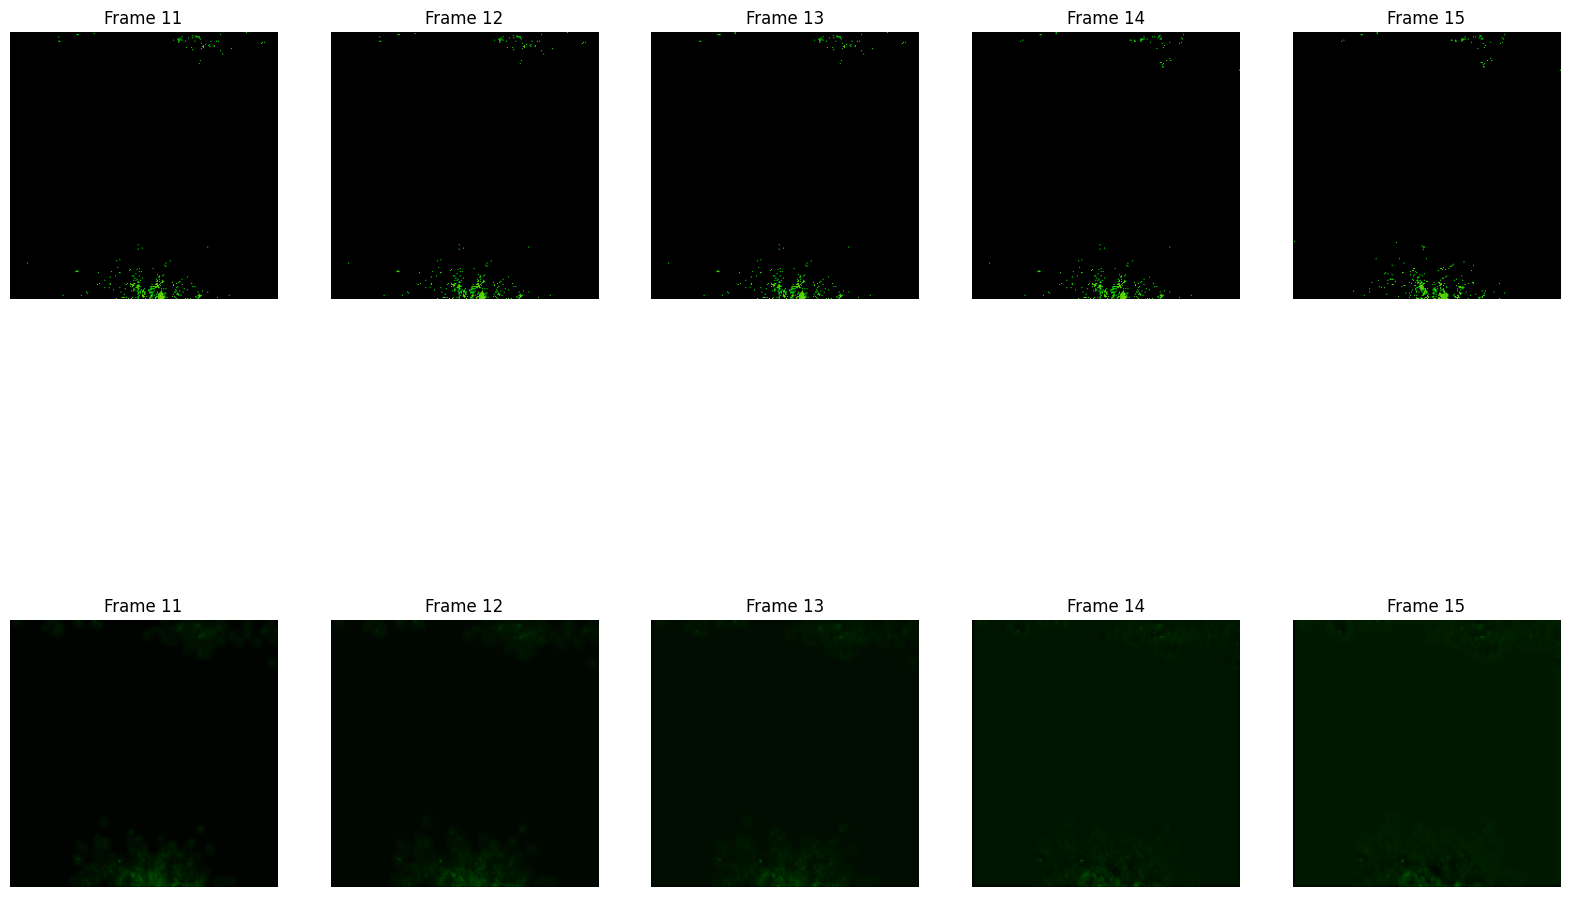

In [14]:
# Select a random example from the validation dataset.
example = X_val[np.random.choice(range(len(X_val)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 14))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [15]:
# Select a few random examples from the dataset.
examples = X_test[np.random.choice(range(len(X_test)), size=1)]


# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [16]:
# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
